In [1]:
import torch

import numpy as np
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from sklearn.impute import SimpleImputer
from data_retrieval import retrieve_data_from_url, prepare_data
import wandb

In [2]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'

In [3]:
df = retrieve_data_from_url(URL)
data, x_df, info = prepare_data(df)

In [4]:
data

,location,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
0,AFG,2020-02-24,1.0,1.0,0.026,0.026,8.33,NaN,NaN,NaN,...,9.59,37.746,0.500,64.83,0.498,NaN,NaN,NaN,54,2
1,AFG,2020-02-25,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.500,64.83,0.498,NaN,NaN,NaN,55,2
2,AFG,2020-02-26,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.500,64.83,0.498,NaN,NaN,NaN,56,2
3,AFG,2020-02-27,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.500,64.83,0.498,NaN,NaN,NaN,57,2
4,AFG,2020-02-28,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.500,64.83,0.498,NaN,NaN,NaN,58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,OWID_WRL,2021-01-19,96167933.0,608286.0,12337.449,78.037,NaN,651838.000,13545.429,83.625,...,8.51,60.130,2.705,72.58,NaN,10.0,6.434,34.635,384,1
61499,OWID_WRL,2021-01-20,96862056.0,694123.0,12426.499,89.050,NaN,643827.429,13717.571,82.597,...,8.51,60.130,2.705,72.58,NaN,10.0,6.434,34.635,385,1
61500,OWID_WRL,2021-01-21,97518881.0,656825.0,12510.763,84.265,NaN,629770.429,13922.143,80.794,...,8.51,60.130,2.705,72.58,NaN,10.0,6.434,34.635,386,1
61501,OWID_WRL,2021-01-22,98177108.0,658227.0,12595.208,84.444,NaN,614414.571,14041.714,78.824,...,8.51,60.130,2.705,72.58,NaN,10.0,6.434,34.635,387,1


In [5]:
x_df.sample(10)

,continent,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers
HKG,Asia,Hong Kong,7496988.0,7039.714,44.8,16.303,10.158,56054.920,NaN,8.33,NaN,NaN,84.86,0.933,NaN,NaN,NaN
BOL,South America,Bolivia,11673029.0,10.202,25.4,6.704,4.393,6885.829,204.299,6.89,25.383,1.10,71.51,0.693,7.1,NaN,NaN
GNB,Africa,Guinea-Bissau,1967998.0,66.191,19.4,3.002,1.565,1548.675,382.474,2.42,6.403,NaN,58.32,0.455,67.1,NaN,NaN
PNG,Oceania,Papua New Guinea,8947027.0,18.220,22.6,3.808,2.142,3823.194,561.494,17.65,NaN,NaN,64.50,0.544,NaN,23.5,48.8
SGP,Asia,Singapore,5850343.0,7915.731,42.4,12.922,7.049,85535.383,92.243,10.99,NaN,2.40,83.62,0.932,NaN,5.2,28.3
LAO,Asia,Laos,7275556.0,29.715,24.4,4.029,2.322,6397.360,368.111,4.00,49.839,1.50,67.92,0.601,22.7,7.3,51.2
HRV,Europe,Croatia,4105268.0,73.726,44.0,19.724,13.053,22669.797,253.782,5.59,NaN,5.54,78.49,0.831,0.7,34.3,39.9
KHM,Asia,Cambodia,16718971.0,90.672,25.6,4.412,2.385,3645.070,270.892,4.00,66.229,0.80,69.82,0.582,NaN,2.0,33.7
LBR,Africa,Liberia,5057677.0,49.127,19.2,3.057,1.756,752.788,272.509,2.42,1.188,0.80,64.10,0.435,38.6,1.5,18.1
MOZ,Africa,Mozambique,31255435.0,37.728,17.7,3.158,1.870,1136.103,329.942,3.30,12.227,0.70,60.85,0.437,62.9,5.1,29.1


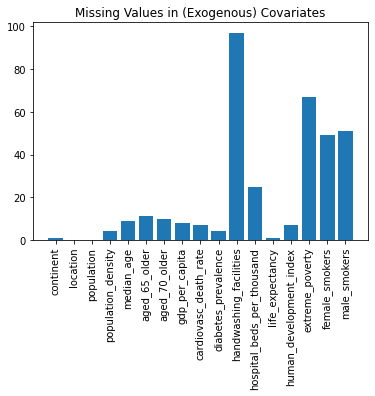

In [6]:
x_nans_sums = info["x_nan_sums"]

x_ax_labels = [k for k,v in x_nans_sums.items()]
x_ax_values = [v for k,v in x_nans_sums.items()]

plt.bar(x_ax_labels,x_ax_values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

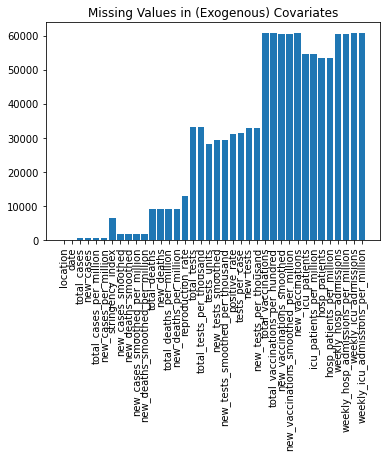

In [7]:
y_nans_sums = info["y_nan_sums"]

y_ax_labels = [k for k,v in y_nans_sums.items()]
y_ax_values = [v for k,v in y_nans_sums.items()]

plt.bar(y_ax_labels,y_ax_values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

In [8]:
len(data.columns)

56

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


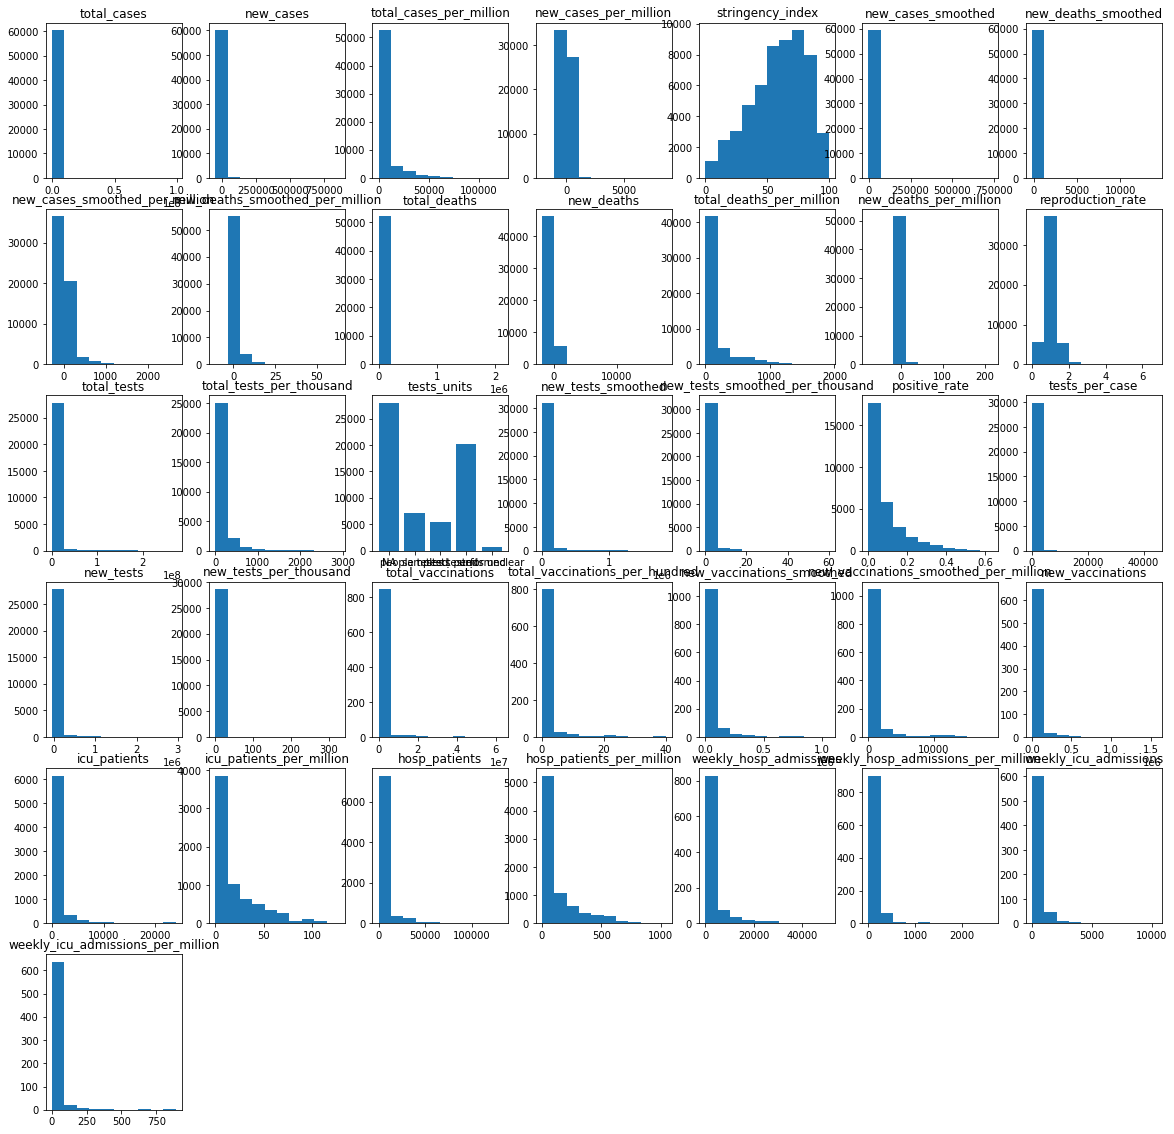

In [9]:
# plot histograms for all (potential) ys
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(20,20))
# ax.set_title("Distribution of Covariates")

i = 0
ys = info["y_nan_sums"].keys()
for x in ys:
    if(x in ['location', 'date']):
        continue
    
    else:
        
        i += 1
        ax = fig.add_subplot(6,7,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

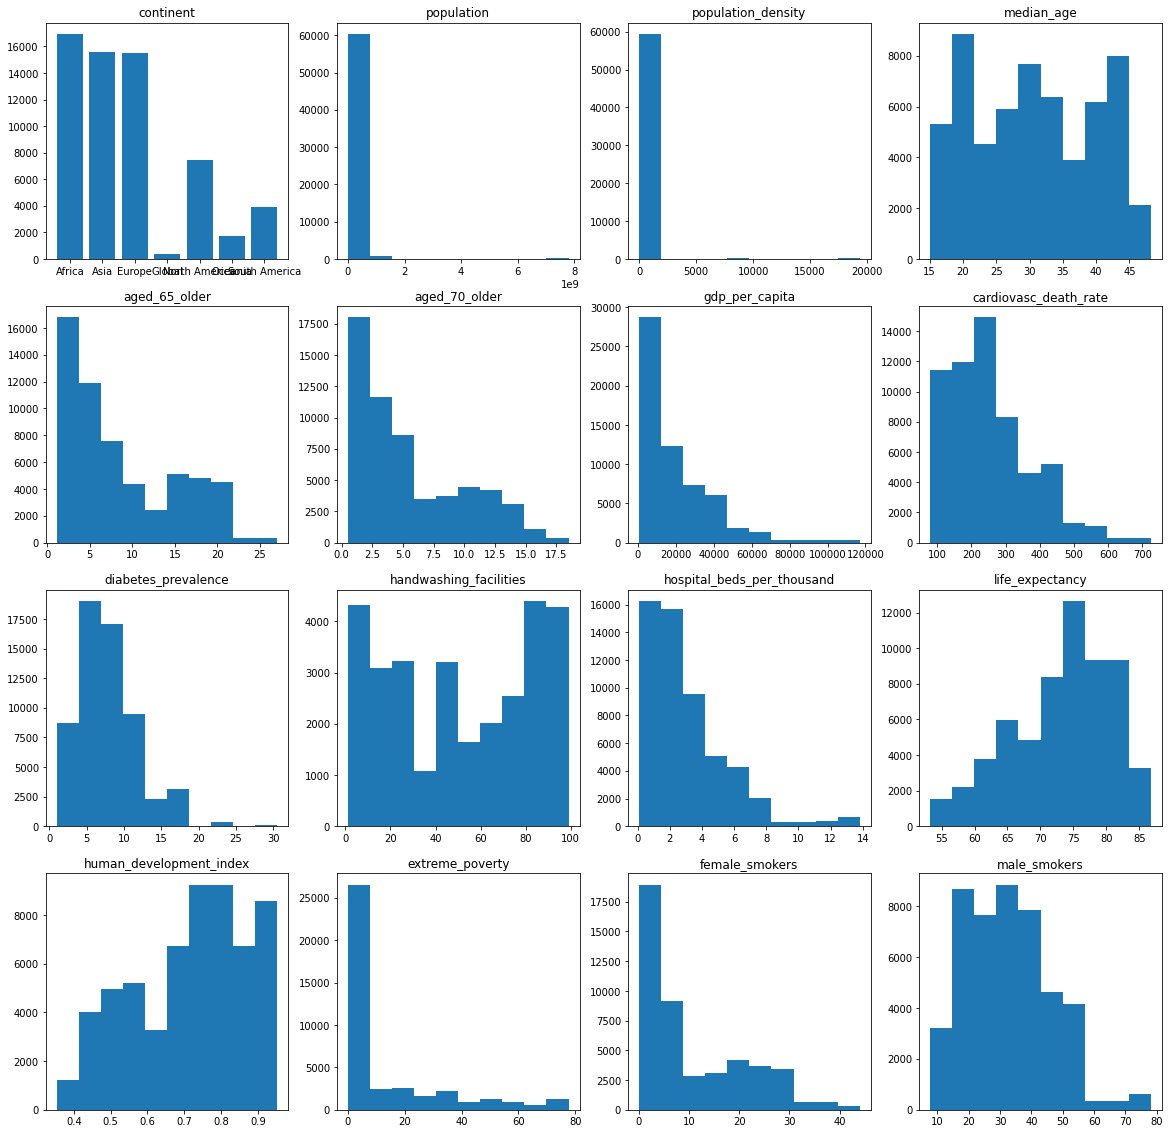

In [10]:
# plot histograms for all (potential) xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(20,20))
# ax.set_title("Distribution of Covariates")

i = 0
xs = info["x_nan_sums"].keys()
for x in xs:
    if(x in ['location', 'date']):
        continue
    else:
        
        i += 1
        ax = fig.add_subplot(4,4,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

In [11]:
# set model parameters for wandb
config = wandb.config

# model configs for wandb

config.max_pred_length = 7 # predict at most one week
config.max_encoder_length = 90  # use at most ~2 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
config.max_epochs = 50
config.gradient_clip_val = 0.07
config.learning_rate = 0.05 # next, try .07
config.hidden_size = 16
# number of attention heads. Set to up to 4 for large datasets
config.attention_head_size = 4
config.dropout = 0.2  # between 0.1 and 0.3 are good values
config.hidden_continuous_size = 8  # set to <= hidden_size
config.output_size = 7  # 7 quantiles by default
# reduce learning rate if no improvement in validation loss after x epochs
config.reduce_on_plateau_patience = 4
config.targets = 'new_cases'
config.static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']
config.transformation = "relu"
config.max_epochs=50
config.impute_strategy = "median"
config.n_neighbors = 8
config.weights = "distance"

In [27]:
# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation following https://www.kaggle.com/dansbecker/handling-missing-values

proto_data = data.copy()

# drop "FSM" (Micronesia) Columns that only appeared as of 2021/01/21
proto_data.drop(index=data.loc[data.location == "FSM"].index, inplace=True)

# data.fillna({name: 0.0 for name in config.static_reals})
# proto_data.fillna({config.targets: 0.0}, inplace=True)

# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*config.static_reals, config.targets] if proto_data[col].isnull().any())
for col in cols_with_missing:
    proto_data[col + '_was_missing'] = proto_data[col].isnull()



# Imputation
imputer = SimpleImputer(strategy=config.impute_strategy)
proto_data[[*config.static_reals, config.targets]] = pd.DataFrame(
    imputer.fit_transform(proto_data[[*config.static_reals, config.targets]]))

# proto_data[[*config.static_reals, config.targets]] = proto_data[[*config.static_reals, config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in proto_data.columns if col.endswith("_was_missing")]

proto_data[impute_dummies] = proto_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = proto_data.loc[proto_data[config.targets].isna()][["location","date"]].copy(deep=True)
proto_data.drop(index=missing_targets.index, inplace=True)



training = TimeSeriesDataSet(
    proto_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units', *impute_dummies],
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 
                              #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
                             ],
    target_normalizer=GroupNormalizer(groups=['location'], transformation=config.transformation),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, proto_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

print("Dropping the following for missing target values: \n\n ", missing_targets)

Dropping the following for missing target values: 

         location       date
61500  OWID_WRL 2021-01-21
61501  OWID_WRL 2021-01-22
61502  OWID_WRL 2021-01-23


In [31]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1695.658935546875

In [29]:
# load best model we have
prediction_model = TemporalFusionTransformer.load_from_checkpoint("delphi_kappa.ckpt")

In [32]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = prediction_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(7391.4448)

Exception in thread Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
QueueFeederThread:
Traceback (most recent call last):
  File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/connection.py", line 177, in close
    close()
      File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/connection.py", line 177, in close
self._close()
  File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/connection.py", line 361, in _close
        self._close()
_close(self._handle)  File "/home/kharuto/.pyenv/versions/3.8.2/lib/python3.8/multiprocessing/connection.py", line 361, in _close

OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback 

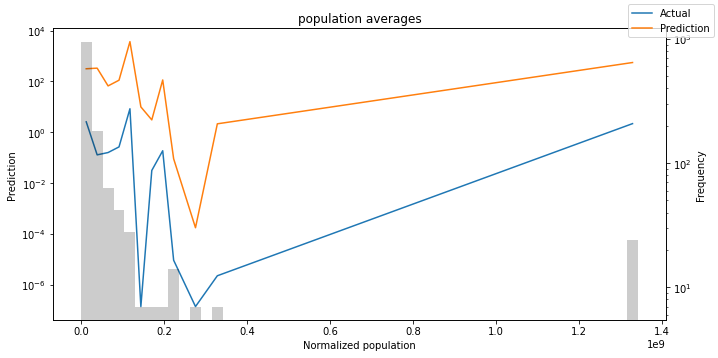

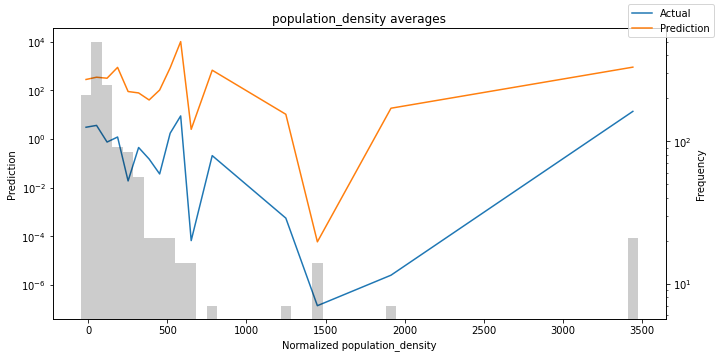

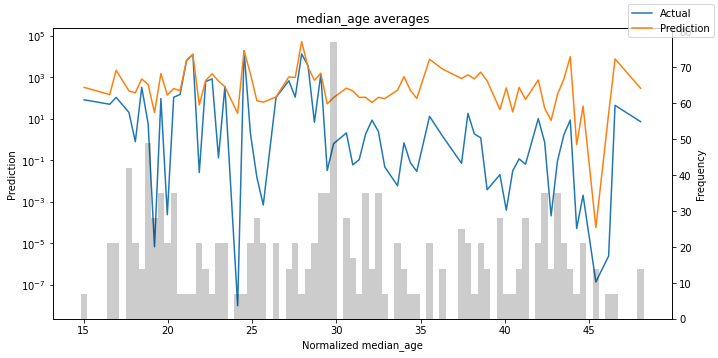

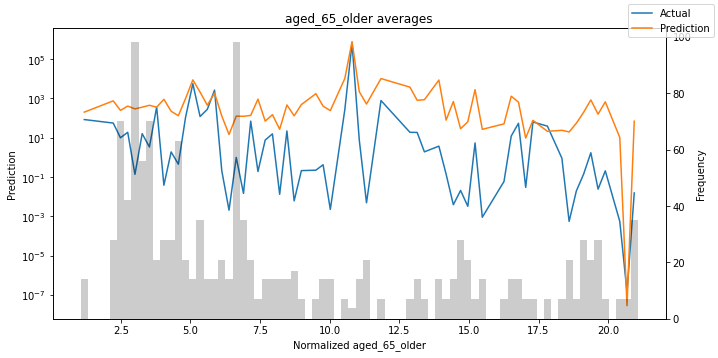

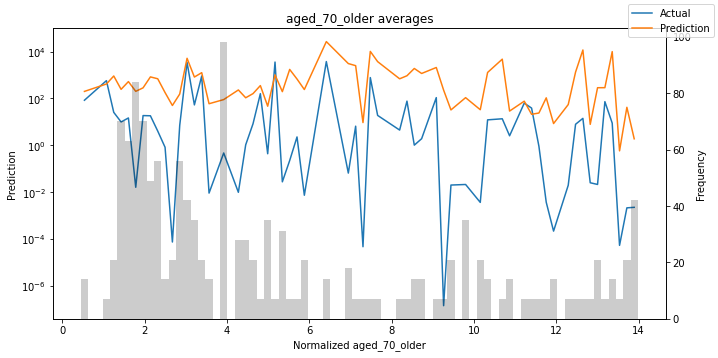

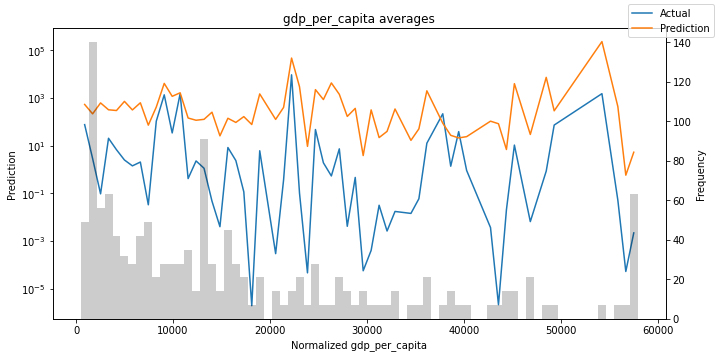

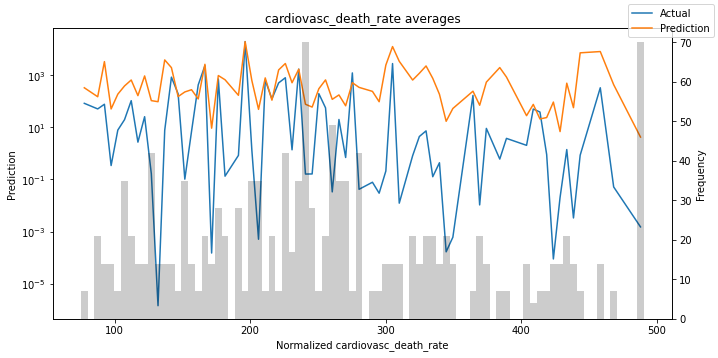

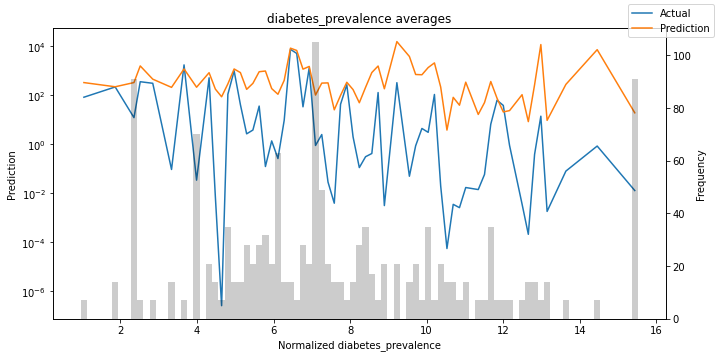

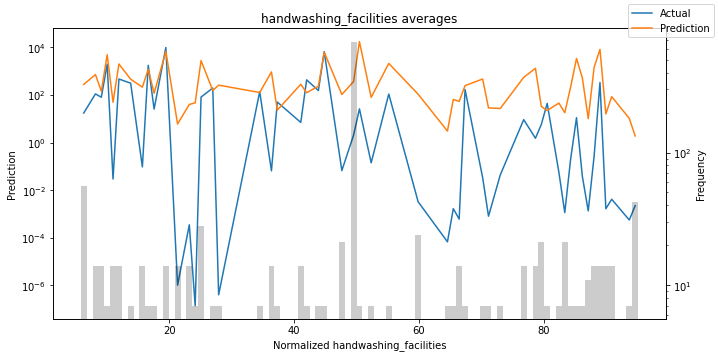

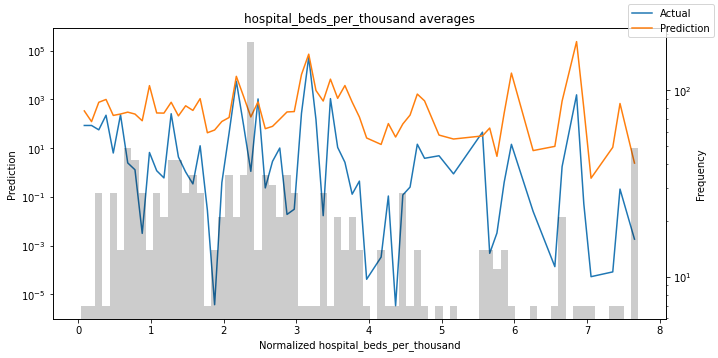

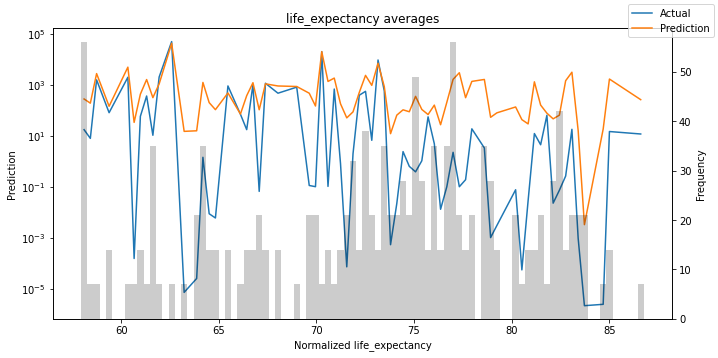

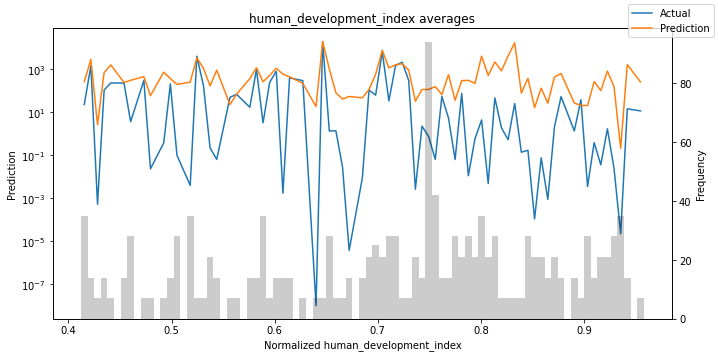

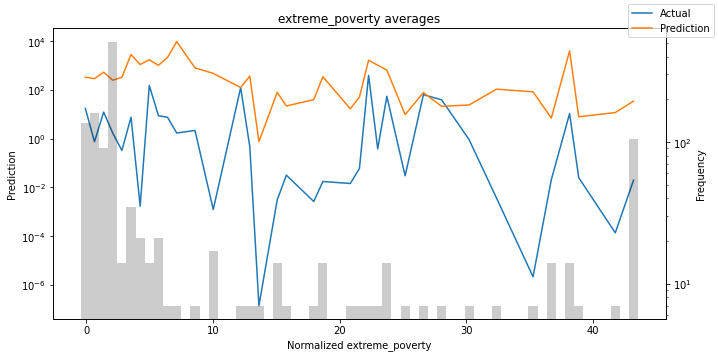

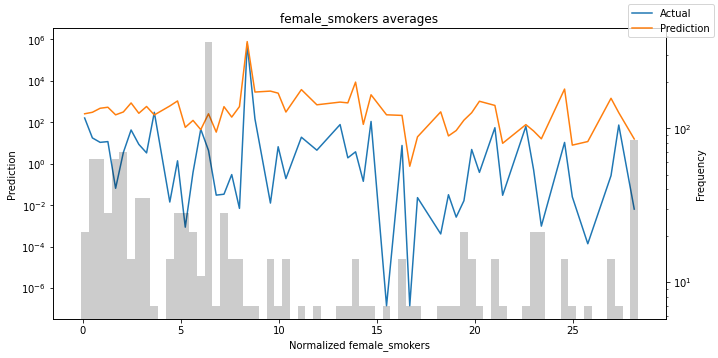

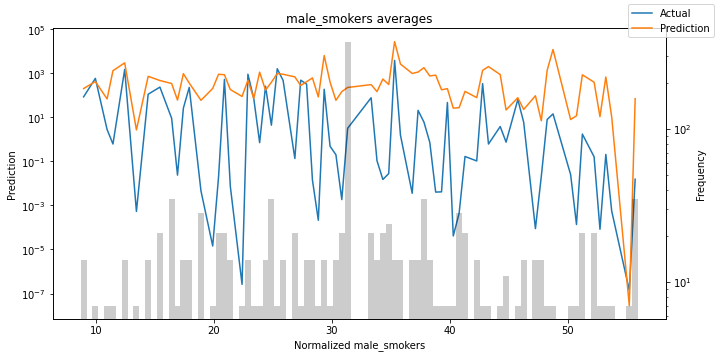

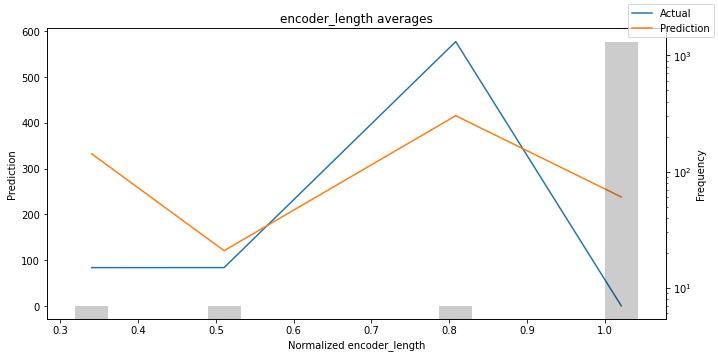

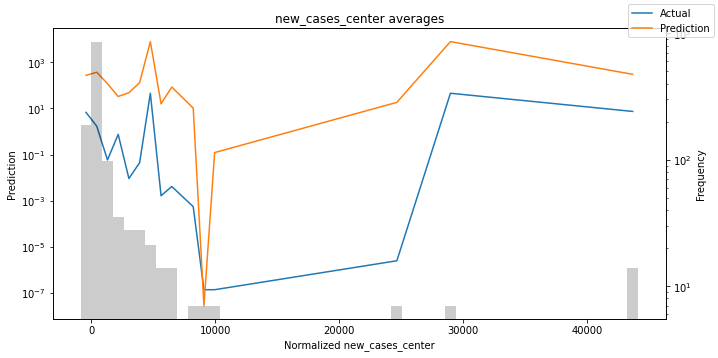

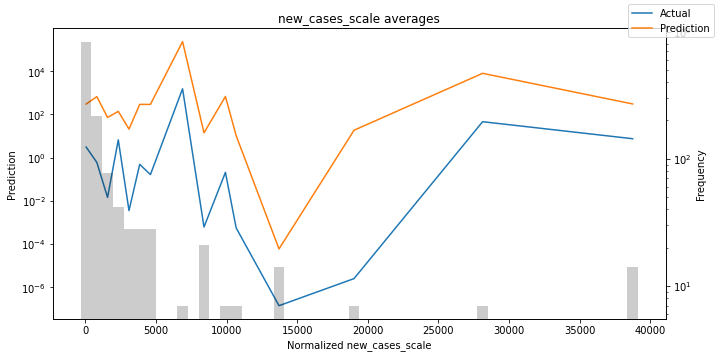

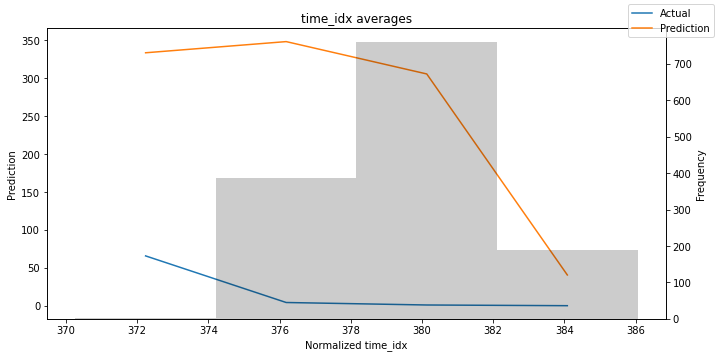

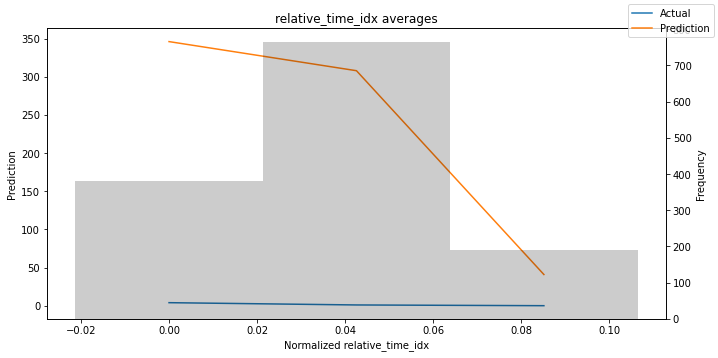

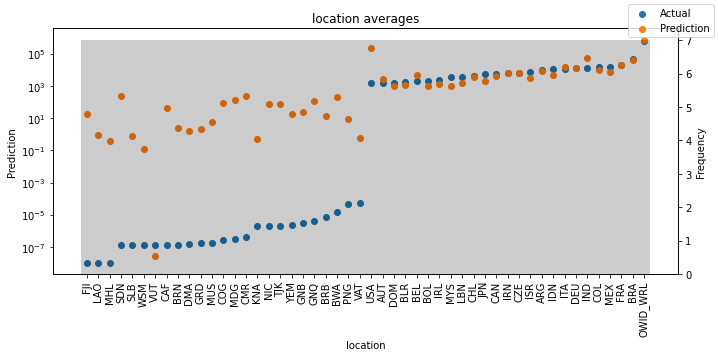

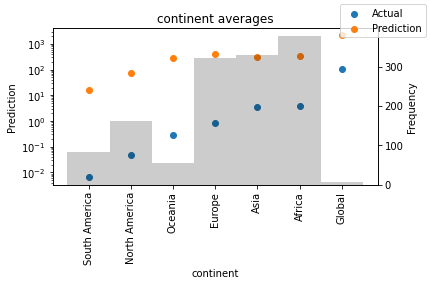

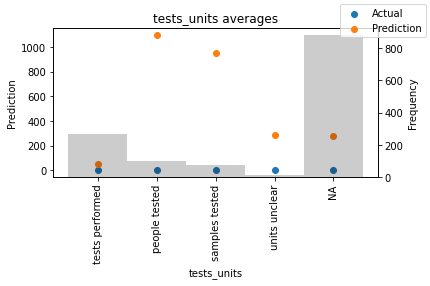

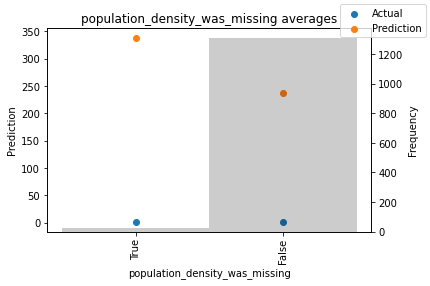

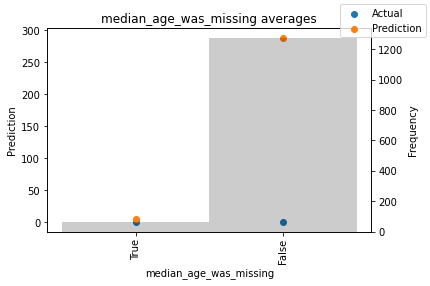

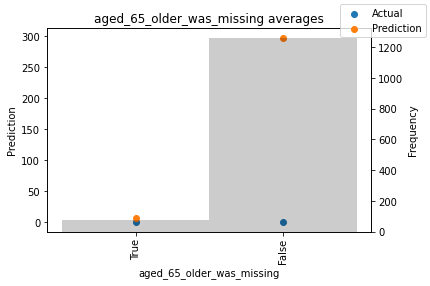

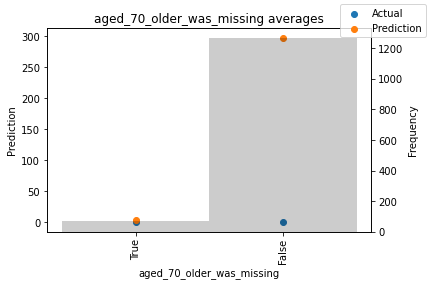

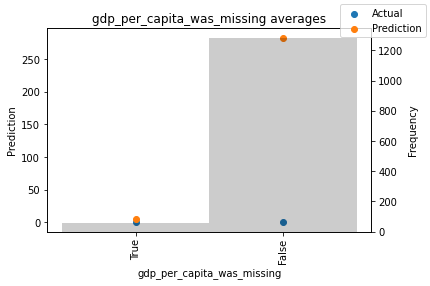

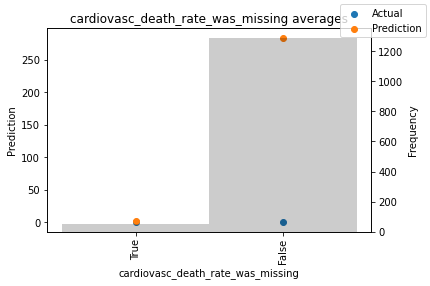

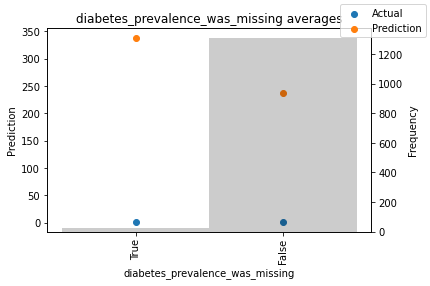

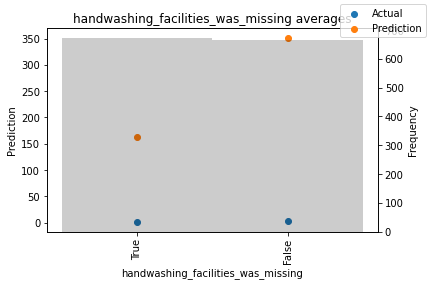

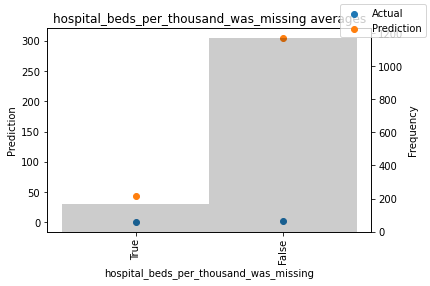

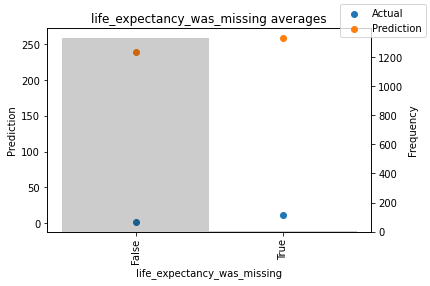

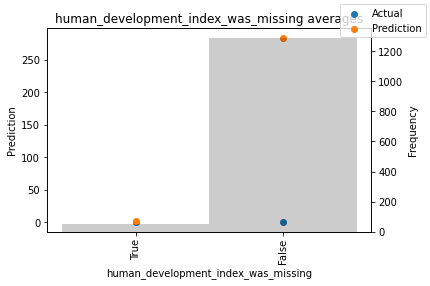

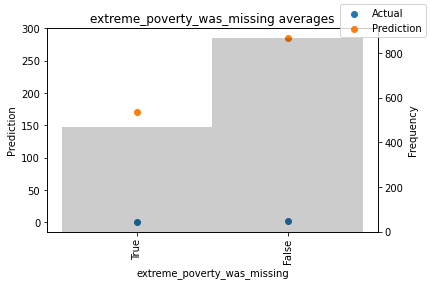

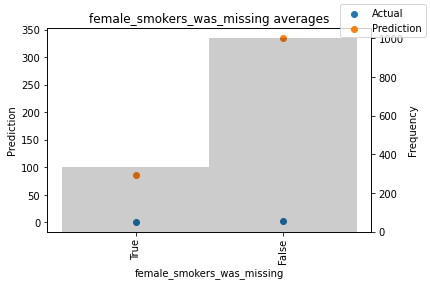

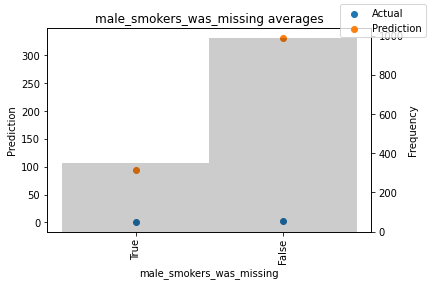

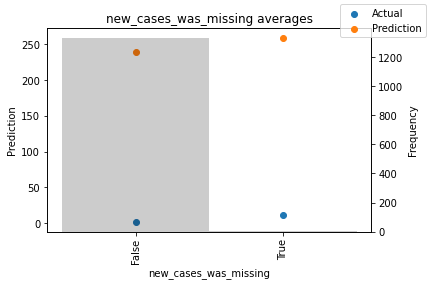

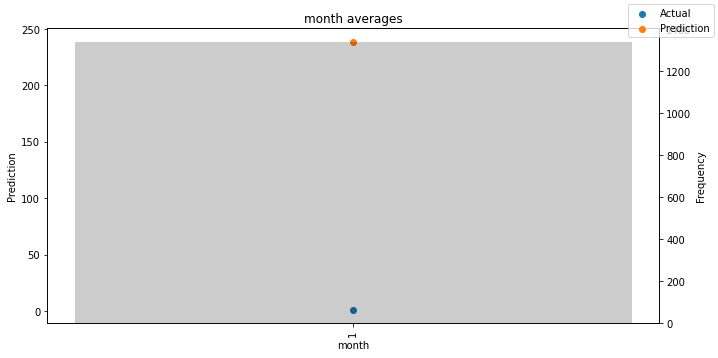

In [36]:
predictions, x = prediction_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = prediction_model.calculate_prediction_actual_by_variable(x, predictions)
prediction_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [37]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pickle

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2021-01-24 17:35:36,282] A new study created in memory with name: no-name-7681a928-79a3-48c8-9c22-72230ef0d1bd
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
[I 2021-01-24 17:38:05,222] Trial 0 finished with value: 669.6585693359375 and parameters: {'gradient_clip_val': 0.01186042523051671, 'hidden_size': 124, 'dropout': 0.22070970766506826, 'hidden_continuous_size': 15, 'attention_head_size': 3, 'learning_rate': 0.03444752946251698}. Best is trial 0 with value: 669.6585693359375.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-24 17:46:04,182] Trial 1 finished with value: 650.7720947265625 and p

NameError: name 'pickle' is not defined

In [38]:


# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.011795913891160366, 'hidden_size': 117, 'dropout': 0.25529556357610206, 'hidden_continuous_size': 87, 'attention_head_size': 1, 'learning_rate': 0.03333919105985481}
